# EXERCICE DE PRATIQUE AVEC PROFESSEUR ERIC MATZNER

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error,roc_curve,roc_auc_score,r2_score
from sklearn.model_selection import cross_val_score,KFold,cross_val_predict,train_test_split,GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler,Normalizer, MaxAbsScaler,normalize #pour normaliser un vecteur 
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier,BaggingRegressor,VotingClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier,AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.feature_extraction import DictVectorizer
#from sklearn.feature_extraction import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import FeatureUnion 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
import time

## Nettoyage

In [2]:
fichier = pd.read_csv("D:/BUREAU/infos/Cours_Eric_Matzner/vin.csv")

In [3]:
fichier.head()

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,mauvais
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,mauvais
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,mauvais
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,bon
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,mauvais


In [4]:
fichier.shape

(1599, 12)

In [5]:
fichier.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed.acidity         1599 non-null   float64
 1   volatile.acidity      1599 non-null   float64
 2   citric.acid           1599 non-null   float64
 3   residual.sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free.sulfur.dioxide   1599 non-null   float64
 6   total.sulfur.dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   object 
dtypes: float64(11), object(1)
memory usage: 150.0+ KB


In [6]:
fichier.isna().sum()

fixed.acidity           0
volatile.acidity        0
citric.acid             0
residual.sugar          0
chlorides               0
free.sulfur.dioxide     0
total.sulfur.dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

On a aucune valeur manquante et toutes nos varaibles sont numeriques

In [4]:
(fichier["quality"]).unique()

array(['mauvais', 'bon'], dtype=object)

In [5]:
proportion_bon = len(fichier[fichier["quality"]=="bon"])/fichier.shape[0]
proportion_mauvais = len(fichier[fichier["quality"]=="mauvais"])/fichier.shape[0]
print(f" %_bon:{proportion_bon}")
print(f" %_mauvais:{proportion_mauvais}")

 %_bon:0.5347091932457786
 %_mauvais:0.4652908067542214


Alors nous sommes dans un cas dans lequel nos données sont bien equilibrées. On pourra donc aisément utilisé l'accuracy 
comme metrique.

In [9]:
# fichier["Ne18"] = pd.to_numeric(fichier["Ne18"].str.replace(".", ""),errors="coerce")

In [6]:
#recodage de la variable cible.

conditions ={"bon":0,"mauvais":1}
fichier["quality"]= fichier["quality"].map(conditions)

In [7]:
(fichier["quality"]).unique()

array([1, 0], dtype=int64)

Pour des soucis de performances, on va reduire notre jeu de données tout en s'assurant qu'on a toujours les memes 
proportaions de bons et de mauvais

In [8]:
X = fichier.drop("quality", axis=1)
Y = fichier["quality"]


X_aband, X_final, Y_aband, Y_final = train_test_split(X, Y, test_size=0.4, stratify=Y, random_state=42)

# On va utiliser X_final ey Y_final comme notre nouveau jeu de données. 
# stratify=Y : va nous permettre d'avoir les modalités de Y dans les memes proportions
# test_size=0.4: Je ne veux conserver que 40% de mon jeu de données de depart

On va verifier qu'on a les memes proportions qu'au depart

In [9]:
proportion_bon = (len(Y_final[Y_final==0])/len(Y_final))
proportion_mauvais = (len(Y_final[Y_final==1])/len(Y_final))

print(f" %_0:{proportion_bon}")
print(f" %_1:{proportion_mauvais}")

 %_0:0.534375
 %_1:0.465625


## Choix du bon Seuil  (certes les données ne sont pas déséquilibrées,  mais je fais quelque chose de global)

Nous sommes dans un cas de classification. Alors le choix du on seuil devient tres important. Il serait mieux d'aller 
avec le seuil naturel(le seuil qui permet de predire dans les memes proportions que les proportios de depart) selon
l'émerite Professeur Eric Matzner.
Comme le random Forest predit en general bien, faisons le choix de notre seuil en implementant un random Forest.

In [10]:
x_train,x_test,y_train,y_test = train_test_split(X_final,Y_final,random_state = 1, test_size = 0.2, stratify =Y_final)

log = RandomForestClassifier()
log.fit(x_train,y_train)
pred_log = log.predict(x_test)
pred_prob = log.predict_proba(x_test)[:,1] #pour avoir les proba dans la classe 1
print(pred_prob.sort())

None


0.4899509803921569


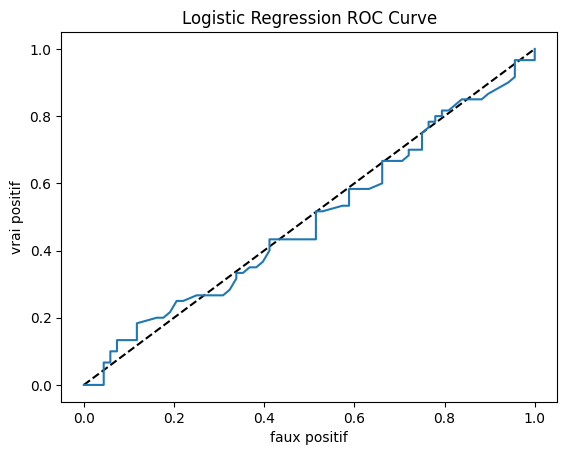

In [11]:
taux_faux_pos, taux_vrai_pos, seuil = roc_curve(y_test,pred_prob)
plt.plot([0,1],[0,1],'k--')
plt.plot(taux_faux_pos, taux_vrai_pos)
plt.xlabel("faux positif")
plt.ylabel("vrai positif")
plt.title("Logistic Regression ROC Curve")
print(roc_auc_score(y_test,pred_prob))

Au regard de la coubre ROC, on remarque que le seuil de base n'est pas du tout bon.

In [12]:
pred_prob #les probas de chaque individu dans la classe 1

array([0.01, 0.02, 0.03, 0.04, 0.04, 0.06, 0.06, 0.06, 0.07, 0.07, 0.08,
       0.08, 0.08, 0.08, 0.08, 0.09, 0.09, 0.1 , 0.1 , 0.1 , 0.11, 0.11,
       0.12, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.22, 0.22, 0.23,
       0.24, 0.24, 0.25, 0.25, 0.26, 0.27, 0.27, 0.28, 0.29, 0.29, 0.3 ,
       0.3 , 0.3 , 0.32, 0.33, 0.33, 0.33, 0.34, 0.34, 0.35, 0.36, 0.36,
       0.36, 0.37, 0.38, 0.38, 0.38, 0.38, 0.39, 0.4 , 0.44, 0.45, 0.46,
       0.46, 0.48, 0.48, 0.5 , 0.53, 0.54, 0.54, 0.55, 0.57, 0.59, 0.6 ,
       0.6 , 0.6 , 0.61, 0.61, 0.62, 0.63, 0.63, 0.64, 0.65, 0.66, 0.66,
       0.66, 0.67, 0.67, 0.68, 0.69, 0.71, 0.71, 0.72, 0.72, 0.72, 0.73,
       0.74, 0.74, 0.74, 0.75, 0.75, 0.77, 0.79, 0.79, 0.79, 0.79, 0.8 ,
       0.81, 0.81, 0.82, 0.84, 0.84, 0.85, 0.87, 0.88, 0.89, 0.89, 0.9 ,
       0.94, 0.95, 0.95, 0.96, 0.97, 0.97, 0.97])

On sait que dans notre jeu de données, on a 0.46% de 1. 

In [13]:
int(0.46*len(pred_prob)) #l'index du seuil

58

In [14]:
seuil_fixe = pred_prob[59]
print(seuil_fixe) #une fois que ta probabilté est superieure ou égale à 0.4, On va te classer mauvais

0.38


Voyons à quoi ressemble la courbe ROC dans avec le nouveau seuil qu'on s'est fixé.

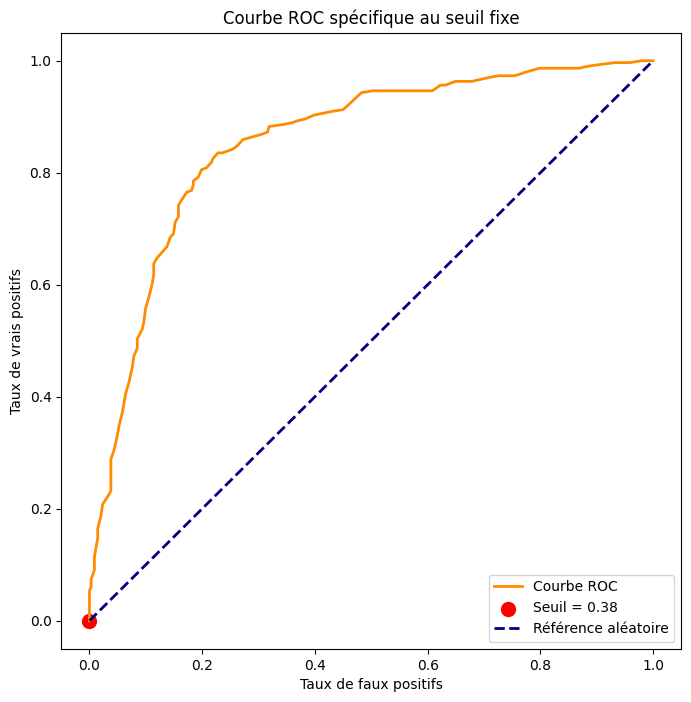

0.8541347776600337


In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


# Création du modèle (Random Forest dans cet exemple)
model = RandomForestClassifier()

# Définir la stratégie de validation croisée
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Effectuer la validation croisée et obtenir les probabilités de classe
probabilities = cross_val_predict(model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]

# Convertissez les probabilités en prédictions en fonction du seuil fixe
predictions = (probabilities > seuil_fixe).astype(int)

# Calculer les taux de faux positifs et les taux de vrais positifs pour votre seuil fixe
fpr, tpr, thresholds = roc_curve(Y_final, probabilities, drop_intermediate=False)
idx_seuil_fixe = np.searchsorted(thresholds, seuil_fixe)
fpr_seuil_fixe = fpr[idx_seuil_fixe]
tpr_seuil_fixe = tpr[idx_seuil_fixe]

# Tracer la courbe ROC spécifique à votre seuil fixe
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Courbe ROC')
plt.scatter(fpr_seuil_fixe, tpr_seuil_fixe, color='red', label=f'Seuil = {seuil_fixe}', s=100, marker='o')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Référence aléatoire')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC spécifique au seuil fixe')
plt.legend(loc="lower right")
plt.show()
print(roc_auc_score(Y_final, probabilities))

AUC = 0.85 on peut dire qu'on a un bon seuil.

## Calibrage de mes differents modeles

In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

### Regression Logistic

In [21]:
# param_grid = {                          
#     "C": [0.00001,0.001,1,10,100],   
#     "solver": ["sag","lbfgs","liblinear"] ,
#     "max_iter" :[10000,11000]
# } 

# ridge = LogisticRegression(penalty="l2")
# ridge_cv = GridSearchCV(ridge, param_grid, cv=kf,scoring="accuracy") 
# ridge_cv.fit(X,Y)

# print(ridge_cv.best_params_)  # Affiche les meilleurs hyperparamètres
# print(ridge_cv.best_score_)   # Affiche le meilleur score de validation croisée (R2 score)

### Ridge

In [22]:
# param_grid = {                          
#     "alpha": [0.00001,0.001,1,10,100],   
#     "solver": ["sag", "lsqr","auto","svd","cholesky"] 
# }                                                      

# ridge = Ridge()

# ridge_cv = GridSearchCV(ridge, param_grid, cv=kf) 
# ridge_cv.fit(x_train, y_train)

# print(ridge_cv.best_params_)  # Affiche les meilleurs hyperparamètres
# print(ridge_cv.best_score_)   # Affiche le meilleur score de validation croisée (R2 score)


### Ridge pour Classification

In [23]:
# param_grid = {                          
#     "C": [0.00001,0.001,1,10,100],   
#     "solver": ["sag","lbfgs","liblinear"] ,
#     "max_iter" :[10000,11000]
# } 


# ridge = LogisticRegression(penalty="l2")
# ridge_cv = GridSearchCV(ridge, param_grid, cv=kf,scoring='accuracy') 
# probabilities = cross_val_predict(model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]

# seuil_fixe = 0.5

# # Convertissez les probabilités en prédictions en fonction du seuil fixe
# predictions = (probabilities > seuil_fixe).astype(int)


# print(ridge_cv.best_params_)  
# print(ridge_cv.best_score_)   

In [24]:
# # Paramètres pour la recherche sur grille
# param_grid = {
#     "C": [0.00001, 0.001, 1, 10, 100],
#     "solver": ["sag", "lbfgs", "liblinear"],
#     "max_iter": [10000, 11000]
# }

# # Modèle de régression logistique
# ridge = LogisticRegression(penalty="l2")

# # Recherche sur grille avec validation croisée
# ridge_cv = GridSearchCV(ridge, param_grid, cv=kf, scoring='accuracy')
# ridge_cv.fit(X_final, Y_final)

# # Afficher les meilleurs paramètres et le meilleur score
# print(ridge_cv.best_params_)
# print(ridge_cv.best_score_)

# # Obtenir les probabilités de classe avec la meilleure configuration
# best_ridge_model = ridge_cv.best_estimator_
# probabilities = cross_val_predict(best_ridge_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]

# # Convertissez les probabilités en prédictions binaires en fonction du seuil fixe
# predictions = (probabilities > seuil_fixe).astype(int)

# # Mesurez la performance avec le seuil fixe
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'C': 1, 'max_iter': 10000, 'solver': 'lbfgs'}
0.7609375
Accuracy avec seuil fixe:0.75


### Lasso

In [25]:
# param_grid = {                          
#     "alpha": [0.00001,0.001,1,10,100],   
#     "solver": ["sag", "lsqr","auto","svd","cholesky"] 
# }                                                      

# lasso = Lasso()

# lasso_cv = GridSearchCV(lasso, param_grid, cv=kf) 
# lasso.fit(X,Y)

# print(lasso_cv.best_params_)  # Affiche les meilleurs hyperparamètres
# print(lasso_cv.best_score_)   # Affiche le meilleur score de validation croisée (R2 score)

### Lasso en  pour Classification

In [26]:
# param_grid = {                          
#     "C": [0.00001,0.001,1,10,100],   
#     "solver": ["liblinear"] ,
#     "max_iter" :[9000,10000,11000]
# } 

# lasso = LogisticRegression(penalty="l1")
# lasso_cv = GridSearchCV(lasso, param_grid, cv=kf,scoring="accuracy") 
# lasso_cv.fit(X_final,Y_final)

# print(lasso_cv.best_params_)  
# print(lasso_cv.best_score_)   

# best_lasso_model = lasso_cv.best_estimator_
# probabilities = cross_val_predict(best_lasso_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]


# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'C': 10, 'max_iter': 11000, 'solver': 'liblinear'}
0.75625
Accuracy avec seuil fixe:0.7578125


## Elasticnets en Classification

In [27]:
# param_grid = {                          
#     "C": [0.00001,0.001,1,10,100],
#     "l1_ratio": [0.1, 0.5, 0.7],
#     "max_iter" :[9000,10000,11000]
# } 

# elastic = LogisticRegression(penalty="elasticnet", solver="saga")
# elastic_cv = GridSearchCV(elastic, param_grid, cv=kf,scoring="accuracy") 
# elastic_cv.fit(X_final,Y_final)

# print(elastic_cv.best_params_)  
# print(elastic_cv.best_score_)   

# best_elastic_model = elastic_cv.best_estimator_
# probabilities = cross_val_predict(best_elastic_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]


# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'C': 1, 'l1_ratio': 0.5, 'max_iter': 9000}
0.75625
Accuracy avec seuil fixe:0.71875


### Regression Logistique

In [28]:
# param_grid = {                          
#     "C": [0.0000001,0.000001,0.00001],   
#     "max_iter" :[10000,11000]
# }

# Logistic = LogisticRegression()

# Logistic_cv = GridSearchCV(Logistic, param_grid, cv=kf,scoring="accuracy") 
# Logistic_cv.fit(X_final,Y_final)

# print(Logistic_cv.best_params_)  
# print(Logistic_cv.best_score_)  

# best_logistic_model = Logistic_cv.best_estimator_
# probabilities = cross_val_predict(best_logistic_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]


# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'C': 1e-05, 'max_iter': 10000}
0.6125
Accuracy avec seuil fixe:0.5015625


### Arbre de Décision Regression

In [29]:
# param_grid = {
#     "max_depth": [1000],
#     "min_samples_split": [15,16,17],
#     "min_samples_leaf": [23,24,25]
# }

# Arbre = DecisionTreeRegressor()

# Arbre_cv = GridSearchCV(Arbre, param_grid, cv=kf)
# Arbre_cv.fit(X,Y)

# print(Arbre_cv.best_params_)
# print(Arbre_cv.best_score_)

### Arbre de Decision Classification

In [30]:
# param_grid = {
#     "max_depth": [500,1000],
#     "min_samples_split": [10,5,15],
#     "min_samples_leaf": [5,7,8]
# }

# Arbre = DecisionTreeClassifier()

# Arbre_cv = GridSearchCV(Arbre, param_grid, cv=kf,scoring="accuracy")
# Arbre_cv.fit(X_final,Y_final)

# print(Arbre_cv.best_params_)
# print(Arbre_cv.best_score_)

# best_Arbre_model = Arbre_cv.best_estimator_
# probabilities = cross_val_predict(best_Arbre_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]


# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'max_depth': 500, 'min_samples_leaf': 8, 'min_samples_split': 5}
0.7546875
Accuracy avec seuil fixe:0.734375


### Random Forest Regression

In [31]:
# a = int((len(fichier.columns))/3)
# param_grid = {                          
#     "n_estimators": [400,700,900,3000],   
#     "min_samples_leaf": [1,3,5],
#     "max_features"= [a-1,a,a+1]
# }

# RandomForest = RandomForestRegressor()

# RandomForest_cv = GridSearchCV(RandomForest, param_grid, cv=kf)
# RandomForest_cv.fit(X,Y)

# print(RandomForest_cv.best_params_)
# print(RandomForest.best_score_)

### Random Forest Classification

In [32]:
# a = int(np.sqrt(len(fichier.columns)))
# param_grid = {                          
#     "n_estimators": [900,1000,1200],   
#     "min_samples_leaf": [1],
#     "max_features": [a-1,a,a+1]
# }

# Random = RandomForestClassifier()

# Random_cv = GridSearchCV(Random, param_grid, cv=kf,scoring="accuracy")
# Random_cv.fit(X_final,Y_final)

# print(Random_cv.best_params_)
# print(Random_cv.best_score_)

# best_Random_model = Random_cv.best_estimator_
# probabilities = cross_val_predict(best_Random_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]


# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'max_features': 2, 'min_samples_leaf': 1, 'n_estimators': 1000}
0.809375
Accuracy avec seuil fixe:0.7953125


### SVM en Regression

### SVM en Classification

In [33]:
# param_grid = {                          
#     "kernel": ['linear','rbf','poly'],   
#     "C": [0.1,1,3,5] 
# }

# svm = SVC(probability=True)

# svm_cv = GridSearchCV(svm, param_grid, cv=kf,scoring="accuracy")
# svm_cv.fit(X_final,Y_final)

# print(svm_cv.best_params_)
# print(svm_cv.best_score_)

# best_svm_model =svm_cv.best_estimator_
# probabilities = cross_val_predict(best_svm_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]

# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'C': 1, 'kernel': 'linear'}
0.7703125
Accuracy avec seuil fixe:0.746875


### XGBoost Regression

In [34]:
# gbm_param_grid = {
#     'colsample_bytree': [0.3, 0.7,0.9],
#     "n_estimators": [500,1000,2000],
#     "max_depth": [2,3,5]
#     "eta_vals" = [0.001, 0.01, 0.1]
# }

# gbm = xgb.XGBRegressor()

# grid_mse = GridSearchCV(estimator=gbm,param_grid=gbm_param_grid,scoring="neg_mean_squared_error",verbose=1,cv=kf)


# # Fit grid_mse to the data
# grid_mse.fit(X_train1,y_train1)

# # Print the best parameters and lowest RMSE
# print("Best parameters found: ", grid_mse.best_params_)
# print("Lowest RMSE found: ", np.sqrt(np.abs(grid_mse.best_score_)))

### XGBoost classification

In [35]:
# param_grid = {
#     'colsample_bytree': [0.6, 0.7,0.8],
#     "n_estimators": [20,25,30,50,100],
#     "max_depth": [10,12,15],
#     "objective":["multi:softmax"],
#     "num_class":[2]
# }

# xgb_classifier = xgb.XGBClassifier() 

# xgb_classifier_cv = GridSearchCV(xgb_classifier,param_grid,cv=kf,scoring="accuracy")
# xgb_classifier_cv.fit(X_final,Y_final)

# print(xgb_classifier_cv.best_params_)
# print(xgb_classifier_cv.best_score_)

# best_xgb_model = xgb_classifier_cv.best_estimator_
# probabilities = cross_val_predict(best_xgb_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]


# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'colsample_bytree': 0.6, 'max_depth': 15, 'n_estimators': 20, 'num_class': 2, 'objective': 'multi:softmax'}
0.790625
Accuracy avec seuil fixe:0.778125


### Gradient Boosting 

In [36]:
# param_grid = {
#     "n_estimators": [100,200,300],
#     "max_depth": [3, 5, 10, 15],   
# }

# gb_classifier = GradientBoostingClassifier()

# gb_classifier_cv = GridSearchCV(gb_classifier, param_grid, cv=kf,scoring="accuracy")
# gb_classifier_cv.fit(X_final, Y_final)


# print(gb_classifier_cv.best_params_)
# print(gb_classifier_cv.best_score_)

# best_gradient_model = gb_classifier_cv.best_estimator_
# probabilities = cross_val_predict(best_gradient_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]

# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'max_depth': 5, 'n_estimators': 100}
0.79375
Accuracy avec seuil fixe:0.7859375


### Adaboost

In [37]:
# param_grid = {
#     "n_estimators": [70,80,100,200],
#     "learning_rate": [0.001,0.1,0.2],
#     "algorithm":["SAMME","SAMME.R"]
# }

# adaboost_classifier = AdaBoostClassifier()

# adaboost_cv = GridSearchCV(adaboost_classifier, param_grid, cv=kf,scoring="accuracy")
# adaboost_cv.fit(X_final, Y_final)

# print(adaboost_cv.best_params_)
# print(adaboost_cv.best_score_)

# best_adaboost_model = adaboost_cv.best_estimator_
# probabilities = cross_val_predict(best_adaboost_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]

# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}
0.7796875
Accuracy avec seuil fixe:0.4703125


### Bagging

In [38]:
# a = int(np.sqrt(len(fichier.columns)))
# param_grid = {
#     "n_estimators": [60,80,200,300],
#     "max_features": [a-1,a,a+1],
# }

# base_classifier = DecisionTreeClassifier()
# bagging_classifier = BaggingClassifier(base_classifier)  

# bagging_classifier_cv = GridSearchCV(bagging_classifier, param_grid, cv=kf,scoring="accuracy")
# bagging_classifier_cv.fit(X_final, Y_final)

# print(bagging_classifier_cv.best_params_)
# print(bagging_classifier_cv.best_score_)

# best_bagging_model = bagging_classifier_cv.best_estimator_
# probabilities = cross_val_predict(best_bagging_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]

# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'max_features': 4, 'n_estimators': 300}
0.7859375
Accuracy avec seuil fixe:0.7625


### K-plus proche voisin

In [39]:
# param_grid = {'n_neighbors':[1,3,5,7]}

# knn = KNeighborsClassifier()
# knn_cv = GridSearchCV(knn, param_grid, cv=kf,scoring="accuracy")
# knn_cv.fit(X_final,Y_final)
# print(knn_cv.best_params_)
# print(knn_cv.best_score_)

# best_knn_model = knn_cv.best_estimator_
# probabilities = cross_val_predict(best_knn_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]

# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'n_neighbors': 1}
0.65625
Accuracy avec seuil fixe:0.65625


## LDA

In [40]:
# param_grid = {
#     "solver": ['svd','lsqr'],
#     "shrinkage": [0.1, 0.15, 0.2, 0.9],   
# }

# lda = LinearDiscriminantAnalysis()
# lda_cv = GridSearchCV(lda, param_grid, cv=kf,scoring="accuracy")
# lda_cv.fit(X_final, Y_final)

# print(lda_cv.best_params_)
# print(lda_cv.best_score_)

# best_lda_model = lda_cv.best_estimator_
# probabilities = cross_val_predict(best_lda_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]

# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")


{'shrinkage': 0.1, 'solver': 'lsqr'}
0.640625
Accuracy avec seuil fixe:0.634375


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Pyth

## QDA

In [47]:
# param ={  
#     'tol':[1e-4,0.001,0.1,0.9],
#     "solver": ['svd','lsqr'],
# }

# qda = LinearDiscriminantAnalysis()
# qda_cv = GridSearchCV(lda, param_grid, cv=kf,scoring="accuracy")
# qda_cv.fit(X_final, Y_final)

# print(qda_cv.best_params_)
# print(qda_cv.best_score_)

# best_qda_model = qda_cv.best_estimator_
# probabilities = cross_val_predict(best_qda_model, X_final, Y_final, cv=kf, method='predict_proba')[:, 1]

# predictions = (probabilities > seuil_fixe).astype(int)
# accuracy = accuracy_score(Y_final, predictions)
# print(f"Accuracy avec seuil fixe:{accuracy}")

{'shrinkage': 0.15, 'solver': 'lsqr'}
0.6359375
Accuracy avec seuil fixe:0.6484375


C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Pyth

## Evaluation du meilleur modele

In [ ]:
# classifiers = [
#     ('Logistic_Logistique', best_logistic_model),
#     ('Classification_Elastic', best_elastic_model),
#     ('Classification_Ridge', best_ridge_model),
#     ('Classification_Lasso', best_lasso_model),
#     ('Arbre', best_Arbre_model),
#     ('Random_Forest', best_Random_model),
#     ('Xgboost', best_xgb_model),
#     ('knn', best_knn_model),
#     ('Gradient_boosting', best_gradient_model),
#     ('adaboost_classifier', best_adaboost_model),
#     ('Bagging', best_bagging_model),
#     ('SVM', best_svm_model),
#     ('LDA', best_lda_model),
#     ('QDA', best_qda_model),
#     ]

# for name, classifier in classifiers:
#     kf = KFold(n_splits=10, shuffle=True, random_state=1)
#     y_pred = cross_val_predict(classifier, X_final, Y_final, cv=kf)
#     acc = accuracy_score(Y_final, y_pred)
#     print(f"{name} : {np.mean(acc)}")



### Meme Processus que le precedant, mais avec tous les modeles dans une memes boucles (Pour ceux qui s'en sortent 😅)

### Choix des meilleurs Parametres

In [16]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
a = int(np.sqrt(len(X_final.columns)))

dico =  {'logistic':LogisticRegression(), 'elastic':LogisticRegression(penalty="elasticnet", solver="saga"),
        'ridge':LogisticRegression(penalty="l2"),'lasso':LogisticRegression(penalty="l1"),
        'Arbre':DecisionTreeClassifier(),'Random':RandomForestClassifier(),'xgb':xgb.XGBClassifier(),
        'knn':KNeighborsClassifier(),'Gradient_boosting':GradientBoostingClassifier(),'adaboost_classifier':AdaBoostClassifier(),
        'Bagging':BaggingClassifier(DecisionTreeClassifier()),'SVM':SVC(probability=True),'LDA':LinearDiscriminantAnalysis(),
        'QDA':LinearDiscriminantAnalysis()}

param = [{"C": [0.0000001,0.000001,0.00001],"max_iter" :[10000,11000]},{"C": [0.00001,0.001,1,10,100],"l1_ratio": [0.1, 0.5, 0.7],
        "max_iter" :[9000,10000,11000]},{"C": [0.00001, 0.001, 1, 10, 100],"solver": ["sag", "lbfgs", "liblinear"],
       "max_iter": [10000, 11000]},{"C": [0.00001,0.001,1,10,100],"solver": ["liblinear"],"max_iter" :[9000,10000,11000]},
        {"max_depth": [500,1000],"min_samples_split": [10,5,15],"min_samples_leaf": [5,7,8]},{"n_estimators": [900,1000,1200],"min_samples_leaf": [1],
       "max_features": [a-1,a,a+1]},{'colsample_bytree': [0.6, 0.7,0.8],"n_estimators": [20,25,30,50,100],"max_depth": [10,12,15],
       "objective":["multi:softmax"],"num_class":[2]},{'n_neighbors':[1,3,5,7]},{"n_estimators": [100,200,300],
       "max_depth": [3, 5, 10, 15]},{"n_estimators": [70,80,100,200],"learning_rate": [0.001,0.1,0.2],"algorithm":["SAMME","SAMME.R"]},
       {"n_estimators": [60,80,200,300],"max_features": [a-1,a,a+1]},{"kernel": ['linear','rbf','poly'],   
       "C": [0.1,1,3,5]},{"solver": ['svd','lsqr'],"shrinkage": [0.1, 0.15, 0.2, 0.9]},
       {'tol':[1e-4,0.001,0.1,0.9],"solver": ['svd','lsqr']}]

meilleurs_parametres = []
Accuracy = []
Accuracy_avec_seuil_fixe = []
Best_Model = []
temps = []
i=0

for nom, model in dico.items():
    model = dico[nom]
    model_cv= GridSearchCV(model, param_grid=param[i], cv=kf,scoring="accuracy")
    temps_debut = time.time()
    model_cv.fit(X_final,Y_final)
    temps_fin = time.time()
    temps_execution = temps_fin - temps_debut
    temps.append(temps_execution)
    #meilleurs_parametres.append(model_cv.best_params_)
    Accuracy.append(model_cv.best_score_)
    best_model = model_cv.best_estimator_
    Best_Model.append(best_model)
    proba = cross_val_predict( best_model,X_final, Y_final, cv = kf, method='predict_proba')[:,1]
    predictions = (proba > seuil_fixe).astype(int)
    accuracy = accuracy_score(Y_final,predictions)
    Accuracy_avec_seuil_fixe.append(accuracy)
    i = i+1
resultats = pd.DataFrame({"modele":['logistic','elasticnet','Ridge','Lasso','Arbre','Random','Xgboost','knn','Gradient_boosting',
                                  'adaboost_classifier', 'Bagging','SVM','LDA','QDA'],
                                   "Accuracy":Accuracy,"Accuracy_avec_seuil":Accuracy_avec_seuil_fixe,'Temps_Execution':temps})
print(resultats)

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Pyth

                 modele  Accuracy  Accuracy_avec_seuil  Temps_Execution
0              logistic  0.612500             0.465625         0.326919
1            elasticnet  0.756250             0.710938       115.529436
2                 Ridge  0.760938             0.740625        26.439204
3                 Lasso  0.756250             0.748437         2.064979
4                 Arbre  0.754687             0.748437         0.589553
5                Random  0.804688             0.785937       149.929924
6               Xgboost  0.790625             0.778125        31.864110
7                   knn  0.656250             0.656250         0.248586
8     Gradient_boosting  0.790625             0.785937        61.303977
9   adaboost_classifier  0.779687             0.465625        33.609842
10              Bagging  0.792188             0.745313        29.626543
11                  SVM  0.770312             0.743750        62.199835
12                  LDA  0.640625             0.620313         0

### Choix du meilleur Modele

In [20]:
liste = [] 
for classif in Best_Model:
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    proba = cross_val_predict(classif,X_final, Y_final, cv = kf, method='predict_proba')[:,1]
    predictions = (proba > seuil_fixe).astype(int)
    acc = accuracy_score(Y_final, predictions)
    liste.append(acc)

resultats_final = pd.DataFrame({"Modele":['logistic','elasticnet','Ridge','Lasso','Arbre','Random','Xgboost','knn','Gradient_boosting',
                                  'adaboost_classifier', 'Bagging','SVM','LDA','QDA'],"Accuracy_seuil":liste})
print(resultats_final)

                 Modele  Accuracy_seuil
0              logistic        0.471875
1            elasticnet        0.712500
2                 Ridge        0.742188
3                 Lasso        0.748437
4                 Arbre        0.732812
5                Random        0.792188
6               Xgboost        0.770312
7                   knn        0.685937
8     Gradient_boosting        0.779687
9   adaboost_classifier        0.476562
10              Bagging        0.760938
11                  SVM        0.740625
12                  LDA        0.632812
13                  QDA        0.746875


##### Conclusion: Les Meilleurs Sont RandomForest , XGBoost et  Gradient Boosting et Bagging qui ont quasiment les memes scores

In [21]:
2**28 -2

268435454